In [2]:
import pandas as pd
import numpy as np
import math
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import utils
%matplotlib inline

In [3]:
FIXED_DATA = ['3u_fixed_x_1.txt', '3mf_I=74.9_A=3_f=.5_tot=2.txt']
FLOATING_DATA = ['3ml_I=744.9_r=5000_tot=1.txt', '3ml_I=744.9_r=5000_tot=1 2.txt']

def load_data(file):
    return pd.read_csv(file, delim_whitespace = True, names=['qpdx', 'qpdy', 'sgx', 'sgy'])

In [4]:
def linear(x, a, b):
    return a*x + b

In [5]:
# STRAIN GAUGE CALIBRATION
# Find strain gauge voltage to distance conversion factors kx and ky
# data recorded by hand
vx = [5.058, 5.076, 5.1, 5.122, 5.15, 5.165, 5.187, 5.215]
x = [10.116, 10.152, 10.2, 10.245, 10.299, 10.331, 10.375, 10.431]
popt, perr, redchisq = utils.fit_model(vx, x, [5e-4]*len(vx), (2, 0), linear)
#print(redchisq)
kx = popt[0]
ekx = perr[0]

vy = [4.992, 5.012, 5.029, 5.055, 5.084, 5.109, 5.123, 5.139]
y = [9.985, 10.024, 10.059, 10.111, 10.168, 10.219, 10.247, 10.278]
popt, perr, redchisq = utils.fit_model(vy, y, [5e-4]*len(vx), (2, 0), linear)
#print(redchisq)
ky = popt[0]
eky = perr[0]

print('kx = ', kx, '+/-', ekx, 'lengths/volts')
print('ky = ', ky, '+/-', eky, 'lengths/volts')

kx =  2.00649763858 +/- 0.00344812153631 lengths/volts
ky =  1.99847730238 +/- 0.0034832531991 lengths/volts


236.319486099
qx =  35.8173775897 +/- 0.00219381414467  lengths/volts
qy =  35.8173775897 +/- 0.00219381414467  lengths/volts


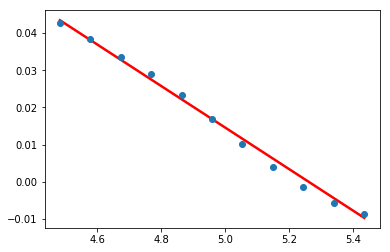

In [6]:
# QPD CALIBRATION
# Find qpd voltage to distance conversion factors qx and qy as functions of laser power

fixed_data = load_data('opttrap/' + FIXED_DATA[0])

# rebin data
BINS = 100
fixed_data['bin'] = pd.cut(fixed_data['sgx'], bins=BINS)
meanbin = fixed_data.groupby('bin').mean()
# TODO: discuss std err on the mean is a good measure of error
stdbin = fixed_data.groupby('bin').std()/(len(fixed_data)/BINS)**.5 

# plot data
#plt.plot(meanbin['sgx'], meanbin['qpdx'])
#plt.show()

# select linear range
SG1 = 42
SG2 = 53

popt, perr, redchisq = utils.fit_model(meanbin['sgx'][SG1:SG2], meanbin['qpdx'][SG1:SG2], stdbin['qpdx'][SG1:SG2], (-1, 10), linear)
print(redchisq)
qx = kx / abs(popt[0]) # [lengths / sg volts] * [sg volts / qpd volts]
eqx = ((ekx/kx)**2 + (perr[0]/popt[0])**2)**.5
print('qx = ', qx, '+/-', eqx, ' lengths/volts')

# assume symmetry until we have more data
qy = qx
eqy = eqx
print('qy = ', qy, '+/-', eqy, ' lengths/volts')

utils.plot_data(meanbin['sgx'][SG1:SG2], meanbin['qpdx'][SG1:SG2], stdbin['qpdx'][SG1:SG2])
utils.plot_model(meanbin['sgx'][SG1:SG2], linear, popt, 'r', '')
plt.show()

In [16]:
# EQUIPARTITION THEOREM ANALYSIS
# \alpha <r^2> = k_B T

# TODO: adjust for stage movement???

floating_data = load_data('opttrap/' + FLOATING_DATA[0])

# calculate <r^2> with correction for <r>
# this is the same as the variance
var = floating_data.var()
varx = var['qpdx']
vary = var['qpdy']

# calculate the error on the variance
# by averaging the errors on the squared x and y redsiduals
floating_data['erxsq'] = (2 * (floating_data['qpdx'] - floating_data['qpdx'].mean()) * 2*5e-8)**2
floating_data['erysq'] = (2 * (floating_data['qpdy'] - floating_data['qpdy'].mean()) * 2*5e-8)**2 
evarx = floating_data['erxsq'].mean()**.5
evary = floating_data['erysq'].mean()**.5

r2 = qx**2 * varx + qy**2 * vary
er2 = (qx**2 * varx) * ((2*qx*eqx / qx)**2 + (evarx / varx)**2)**.5 
+ (qy**2 * vary) * ((2*qy*eqy / qy)**2 + (evary / vary)**2)**.5

print('<r^2> = ',  r2, '+/-', er2)

<r^2> =  0.056785874271 +/- 0.000150526918418


In [13]:
# Assuming we're looking for k_B

# Temperature based on my memory (fix with actual)
t = 22.4 + 273
et = .1

# Need to get alpha from a different calculation
a = 1 # dummy
ea = 0 # dummy

kB = a * r2 / t
ekB = kB * ((ea / a)**2 + (er2 / r2)**2 + (et / t)**2)**.5
print('kB = ', kB, '+/-', ekB)

kB =  7.36383425848e-05 +/- 1.82984087214e-07


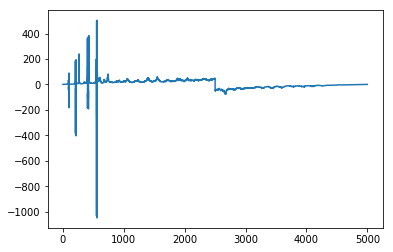

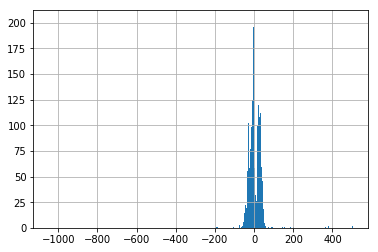

In [26]:
# PSD Analysis
floating_data = load_data('opttrap/' + FLOATING_DATA[0])
freq = np.fft.fftfreq(len(floating_data), floating_data['qpdx'])
plt.plot(freq)
plt.show()
freq.hist(bins=1000)